# Moirai Base vs Fine-tuned (LoRA) - Comparison

This notebook compares the **base Moirai-2 model** against the **fine-tuned version with LoRA adapters**.

We use the same recursive forecasting approach as `recursive_forecasting.ipynb`:
- Country: DE (Germany)
- Period: 2020-10-01 to 2025-01-01
- Horizon: 4 quarters per forecast
- Quantiles: [0.1, 0.5, 0.9]


## 1. Setup and Imports


In [1]:
# Add project root to Python path
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from ecb_forecast.compare import Moirai2Runner, resolve_device, parse_torch_dtype
from ecb_forecast.datasets import (
    load_quarterly_dataset,
    prepare_country_context,
    prepare_moirai_inputs,
)
from uni2ts.model.moirai2 import Moirai2Module, Moirai2Forecast

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {resolve_device('auto')}")


✅ Imports successful!
PyTorch version: 2.4.1
Device available: mps


## 2. Configuration


In [2]:
# Paths
DATA_DIR = project_root / "data" / "processed"
COMBINED_FILE = DATA_DIR / "investment_quarterly.csv"
RESULTS_DIR = project_root / "results"
LORA_DIR = RESULTS_DIR / "lora_DE"
LORA_ADAPTER_PATH = LORA_DIR / "moirai2_lora_adapter.pt"

# Dataset columns
ID_COLUMN = "country"
TIMESTAMP_COLUMN = "timestamp"
TARGET_COLUMN = "investment"

# Forecasting parameters (same as recursive_forecasting.ipynb)
TARGET_COUNTRY = "DE"
RECURSIVE_START_DATE = "2020-10-01"
RECURSIVE_END_DATE = "2025-01-01"
RECURSIVE_HORIZON = 4  # quarters
QUANTILE_LEVELS = [0.1, 0.5, 0.9]

# Model configuration
MOIRAI_MODEL = "Salesforce/moirai-2.0-R-small"
DEVICE = "auto"
MOIRAI_DTYPE = "bfloat16"

print(f"🎯 Configuration:")
print(f"  Country: {TARGET_COUNTRY}")
print(f"  Period: {RECURSIVE_START_DATE} → {RECURSIVE_END_DATE}")
print(f"  Horizon: {RECURSIVE_HORIZON} quarters")
print(f"  LoRA adapter: {LORA_ADAPTER_PATH.exists() and 'Found ✅' or 'Not found ❌'}")


🎯 Configuration:
  Country: DE
  Period: 2020-10-01 → 2025-01-01
  Horizon: 4 quarters
  LoRA adapter: Found ✅


## 3. Load Data


In [3]:
df_full, dataset_summary = load_quarterly_dataset(
    COMBINED_FILE,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
)

print(f"📊 Data loaded: {dataset_summary.num_rows} observations")
print(f"Countries: {dataset_summary.series_ids}")
print(f"Period: {dataset_summary.start.date()} → {dataset_summary.end.date()}")

df_full.head()


📊 Data loaded: 496 observations
Countries: ['DE', 'ES', 'FR', 'IT']
Period: 1995-01-01 → 2025-10-01


,country,investment,investment_qoq,gdp,gdp_qoq,capacityprod_kg,capacityprod_ind,capacityutil_ind,capacityutil_kg,production_kg,...,orders_kg,exportorders_kg,expectedprod_kg,confidence_ind,orders_ind,exportorders_ind,expectedprod_ind,eei,timestamp,interest_rate
0,DE,31184.89,NaN,635687.43,NaN,11.2,13.9,84.349361,90.940051,NaN,...,-16.780977,-20.133333,22.283802,-1.890940,-16.496572,-27.814179,14.333097,95.266918,1995-01-01,7.432433
1,DE,31017.59,-0.537922,640777.12,0.797471,27.2,16.0,84.555137,85.447164,NaN,...,-15.364925,-18.300000,6.527275,-6.286330,-17.222819,-29.793289,5.311969,99.179924,1995-04-01,6.911238
2,DE,31647.75,2.011259,642071.09,0.201734,23.4,17.0,83.993828,83.946850,NaN,...,-17.168103,-15.400000,7.434031,-10.505105,-22.983488,-30.462502,1.416328,98.259968,1995-07-01,6.731235
3,DE,32071.58,1.330322,642329.89,0.040299,24.2,22.2,83.640921,86.561694,NaN,...,-16.479279,-18.266667,9.448246,-12.659780,-27.401496,-33.230317,1.011395,93.585268,1995-10-01,6.327264
4,DE,31569.64,-1.577438,637758.07,-0.714301,26.6,27.4,82.072253,83.743998,NaN,...,-27.405455,-21.900000,-6.392925,-20.115165,-36.576565,-37.828439,-6.917419,93.294153,1996-01-01,6.178932


## 4. Load Models

We'll load:
1. **Base Moirai-2**: Pre-trained model without any fine-tuning
2. **Fine-tuned Moirai-2**: Same model with LoRA adapters trained on DE data


In [4]:
print("🔄 Loading base Moirai-2 model...")

moirai_device = resolve_device(DEVICE)
if moirai_device == "mps":
    print("⚠️  MPS detected - using CPU for Moirai-2 (better compatibility)")
    moirai_device = "cpu"

moirai_dtype = parse_torch_dtype(MOIRAI_DTYPE)

# Base model runner
base_runner = Moirai2Runner(
    model_name=MOIRAI_MODEL,
    device_map=moirai_device,
    dtype=moirai_dtype
)

print("✅ Base Moirai-2 model loaded!")
print(f"   Device: {moirai_device}")
print(f"   Dtype: {moirai_dtype}")


🔄 Loading base Moirai-2 model...
⚠️  MPS detected - using CPU for Moirai-2 (better compatibility)
✅ Base Moirai-2 model loaded!
   Device: cpu
   Dtype: torch.bfloat16


In [5]:
print("🔄 Loading fine-tuned Moirai-2 model with LoRA adapters...")

# Load the base module
module_finetuned = Moirai2Module.from_pretrained(
    MOIRAI_MODEL,
    map_location=moirai_device
)

# Load LoRA adapter weights
checkpoint = torch.load(LORA_ADAPTER_PATH, map_location=moirai_device)
lora_metadata = checkpoint['metadata']
lora_state_dict = checkpoint['state_dict']

print(f"📋 LoRA adapter metadata:")
print(f"   Rank: {lora_metadata['lora_rank']}")
print(f"   Alpha: {lora_metadata['lora_alpha']}")
print(f"   Training epochs: {lora_metadata['epochs']}")
print(f"   Best validation pinball loss: {lora_metadata['best_val_pinball']:.2f}")

# We need to reconstruct the LoRA layers and load the weights
from scripts.finetune_moirai_lora import attach_lora_adapters, LoRALinear

lora_targets = lora_metadata['lora_targets']
replaced = attach_lora_adapters(
    module_finetuned,
    target_suffixes=lora_targets,
    rank=lora_metadata['lora_rank'],
    alpha=lora_metadata['lora_alpha'],
    dropout=0.0,  # No dropout during inference
)

# Load the trained LoRA weights
module_finetuned.load_state_dict(lora_state_dict, strict=False)
module_finetuned.eval()
module_finetuned.to(moirai_device)

print(f"✅ Fine-tuned model loaded with {len(replaced)} LoRA adapters!")


🔄 Loading fine-tuned Moirai-2 model with LoRA adapters...
📋 LoRA adapter metadata:
   Rank: 8
   Alpha: 16.0
   Training epochs: 5
   Best validation pinball loss: 4181.22
✅ Fine-tuned model loaded with 42 LoRA adapters!


## 5. Recursive Forecasting Function

We'll use a simplified function that works with both base and fine-tuned models.


In [6]:
# Use the existing recursive forecast function from the main notebook
def recursive_forecast_moirai(
    full_df,
    country,
    start_date,
    end_date,
    horizon=4,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="country",
    timestamp_column="timestamp",
    target_column="investment"
):
    """Perform recursive forecasting with Moirai-2 (base model)."""
    results = []
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)
    
    country_df = full_df[full_df[id_column] == country].copy()
    country_df = country_df.sort_values(timestamp_column).reset_index(drop=True)
    all_timestamps = sorted(country_df[timestamp_column].unique())
    forecast_origins = [ts for ts in all_timestamps if start_ts <= ts <= end_ts]
    
    print(f"🔄 Performing recursive forecasting for {country} - Base Moirai")
    print(f"  Number of forecast origins: {len(forecast_origins)}")
    print(f"  Horizon per origin: {horizon} quarters")
    
    for idx, origin_date in enumerate(forecast_origins):
        context_data = country_df[country_df[timestamp_column] <= origin_date].copy()
        if len(context_data) < 4:
            continue
        
        try:
            forecast_context = prepare_country_context(
                context_data, prediction_length=horizon, series_id=country,
                id_column=id_column, timestamp_column=timestamp_column, target_column=target_column,
            )
            context_values, start_timestamp, freq = prepare_moirai_inputs(
                forecast_context.dataframe, timestamp_column=timestamp_column, target_column=target_column,
            )
            
            moirai_result = base_runner.run(
                values=context_values, prediction_length=horizon, quantile_levels=quantile_levels,
                forecast_index=forecast_context.forecast_index, start_timestamp=start_timestamp, freq=freq
            )
            
            forecast_df = moirai_result.df.copy()
            forecast_df['origin_date'] = origin_date
            forecast_df['horizon_step'] = range(1, horizon + 1)
            forecast_df['model'] = 'Base Moirai'
            results.append(forecast_df)
            
            if (idx + 1) % 5 == 0:
                print(f"  Completed {idx + 1}/{len(forecast_origins)} forecast origins...")
        except Exception as e:
            print(f"  Warning: Failed for origin {origin_date}: {e}")
            continue
    
    all_forecasts = pd.concat(results, ignore_index=True)
    print(f"✅ Completed {len(forecast_origins)} recursive forecasts")
    return all_forecasts

print("✅ Recursive forecasting function defined")


✅ Recursive forecasting function defined


In [7]:

def recursive_forecast_finetuned(
    full_df,
    module,
    country,
    start_date,
    end_date,
    horizon=4,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="country",
    timestamp_column="timestamp",
    target_column="investment",
    context_length=40,
):
    """Perform recursive forecasting with fine-tuned Moirai-2."""
    results = []
    start_ts = pd.to_datetime(start_date)
    end_ts = pd.to_datetime(end_date)

    country_df = full_df[full_df[id_column] == country].copy()
    country_df = country_df.sort_values(timestamp_column).reset_index(drop=True)
    all_timestamps = sorted(country_df[timestamp_column].unique())
    forecast_origins = [ts for ts in all_timestamps if start_ts <= ts <= end_ts]

    print(f"🔄 Performing recursive forecasting for {country} - Fine-tuned Moirai")
    print(f"  Number of forecast origins: {len(forecast_origins)}")
    print(f"  Context length: {context_length}")

    device = next(module.parameters()).device
    forecast_model = Moirai2Forecast(
        prediction_length=horizon,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
        context_length=context_length,
        module=module,
    )
    forecast_model.to(device)
    forecast_model.eval()

    module_quantiles = list(float(q) for q in module.quantile_levels)
    quantile_indices = {}
    for level in quantile_levels:
        match_idx = next(
            (idx for idx, q in enumerate(module_quantiles) if np.isclose(q, level)),
            None,
        )
        if match_idx is None:
            raise ValueError(
                f"Requested quantile {level} is not supported by the fine-tuned model."
            )
        quantile_indices[level] = match_idx

    for idx, origin_date in enumerate(forecast_origins):
        context_data = country_df[country_df[timestamp_column] <= origin_date].copy()
        if len(context_data) < 4:
            continue

        try:
            forecast_context = prepare_country_context(
                context_data,
                prediction_length=horizon,
                series_id=country,
                id_column=id_column,
                timestamp_column=timestamp_column,
                target_column=target_column,
            )
            context_values, _, _ = prepare_moirai_inputs(
                forecast_context.dataframe,
                timestamp_column=timestamp_column,
                target_column=target_column,
            )

            with torch.no_grad():
                prediction_array = forecast_model.predict([context_values])

            predictions_np = prediction_array[0]  # shape: (num_quantiles, horizon)
            forecast_dates = pd.date_range(
                start=origin_date + pd.DateOffset(months=3),
                periods=horizon,
                freq='QS',
            )

            quantile_columns = {}
            for level in quantile_levels:
                column_name = f"moirai_p{int(round(level * 100)):02d}"
                quantile_columns[column_name] = predictions_np[quantile_indices[level], :]

            forecast_df = pd.DataFrame(
                {
                    'timestamp': forecast_dates,
                    **quantile_columns,
                    'origin_date': origin_date,
                    'horizon_step': range(1, horizon + 1),
                    'model': 'Fine-tuned Moirai',
                }
            )
            results.append(forecast_df)

            if (idx + 1) % 5 == 0:
                print(f"  Completed {idx + 1}/{len(forecast_origins)} forecast origins...")
        except Exception as e:
            print(f"  Warning: Failed for origin {origin_date}: {e}")
            continue

    if not results:
        raise ValueError("No recursive forecasts were produced. Check the warnings above for details.")

    all_forecasts = pd.concat(results, ignore_index=True)
    print(f"✅ Completed {len(forecast_origins)} recursive forecasts")
    return all_forecasts

print("✅ Fine-tuned forecasting function defined")


✅ Fine-tuned forecasting function defined


## 6. Generate Forecasts


In [8]:
# Base model forecasts
forecasts_base = recursive_forecast_moirai(
    full_df=df_full,
    country=TARGET_COUNTRY,
    start_date=RECURSIVE_START_DATE,
    end_date=RECURSIVE_END_DATE,
    horizon=RECURSIVE_HORIZON,
    quantile_levels=QUANTILE_LEVELS,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
    target_column=TARGET_COLUMN
)

print(f"\n📊 Base model forecasts: {len(forecasts_base)} predictions")
forecasts_base.head()


The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data;

🔄 Performing recursive forecasting for DE - Base Moirai
  Number of forecast origins: 18
  Horizon per origin: 4 quarters
  Completed 5/18 forecast origins...
  Completed 10/18 forecast origins...


The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.


  Completed 15/18 forecast origins...


The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.


✅ Completed 18 recursive forecasts

📊 Base model forecasts: 72 predictions


,timestamp,moirai_p10,moirai_p50,moirai_p90,moirai_mean,origin_date,horizon_step,model
0,2021-01-01,53215.886719,57534.367188,61504.871094,57534.367188,2020-10-01,1,Base Moirai
1,2021-04-01,51428.304688,57400.113281,62532.062500,57400.113281,2020-10-01,2,Base Moirai
2,2021-07-01,50014.484375,57129.488281,62919.664062,57129.488281,2020-10-01,3,Base Moirai
3,2021-10-01,49307.007812,57231.507812,63496.878906,57231.507812,2020-10-01,4,Base Moirai
4,2021-04-01,53338.000000,57168.593750,60769.457031,57168.593750,2021-01-01,1,Base Moirai


## 5. Recursive Forecasting Function

We'll use a simplified function that works with both base and fine-tuned models.


In [9]:
# Fine-tuned model forecasts
forecasts_finetuned = recursive_forecast_finetuned(
    full_df=df_full,
    module=module_finetuned,
    country=TARGET_COUNTRY,
    start_date=RECURSIVE_START_DATE,
    end_date=RECURSIVE_END_DATE,
    horizon=RECURSIVE_HORIZON,
    quantile_levels=QUANTILE_LEVELS,
    id_column=ID_COLUMN,
    timestamp_column=TIMESTAMP_COLUMN,
    target_column=TARGET_COLUMN,
    context_length=lora_metadata.get("context_length", 40),
)

print(f"\n📊 Fine-tuned model forecasts: {len(forecasts_finetuned)} predictions")
forecasts_finetuned.head()


🔄 Performing recursive forecasting for DE - Fine-tuned Moirai
  Number of forecast origins: 18
  Context length: 40
  Completed 5/18 forecast origins...
  Completed 10/18 forecast origins...
  Completed 15/18 forecast origins...
✅ Completed 18 recursive forecasts

📊 Fine-tuned model forecasts: 72 predictions


,timestamp,moirai_p10,moirai_p50,moirai_p90,origin_date,horizon_step,model
0,2021-01-01,55565.859375,58016.015625,60558.390625,2020-10-01,1,Fine-tuned Moirai
1,2021-04-01,55053.058594,58135.335938,61358.273438,2020-10-01,2,Fine-tuned Moirai
2,2021-07-01,54603.488281,58365.722656,62063.671875,2020-10-01,3,Fine-tuned Moirai
3,2021-10-01,54575.949219,58526.085938,62081.414062,2020-10-01,4,Fine-tuned Moirai
4,2021-04-01,55602.675781,57757.105469,59924.207031,2021-01-01,1,Fine-tuned Moirai


## 7. Add Ground Truth and Calculate Metrics


In [10]:
# Add ground truth
actual_country = df_full[df_full[ID_COLUMN] == TARGET_COUNTRY].copy()
actual_dict = dict(zip(actual_country[TIMESTAMP_COLUMN], actual_country[TARGET_COLUMN]))

forecasts_base['actual'] = forecasts_base[TIMESTAMP_COLUMN].map(actual_dict)
forecasts_finetuned['actual'] = forecasts_finetuned[TIMESTAMP_COLUMN].map(actual_dict)

print(f"✅ Ground truth values added")
print(f"Base: {forecasts_base['actual'].notna().sum()} with actual values")
print(f"Fine-tuned: {forecasts_finetuned['actual'].notna().sum()} with actual values")


✅ Ground truth values added
Base: 66 with actual values
Fine-tuned: 66 with actual values


In [11]:
def calculate_metrics(forecasts_df, model_name='Model'):
    """Calculate forecast accuracy metrics."""
    with_actual = forecasts_df[forecasts_df['actual'].notna()].copy()
    if len(with_actual) == 0:
        return None, None
    
    with_actual['error'] = with_actual['moirai_p50'] - with_actual['actual']
    with_actual['abs_error'] = np.abs(with_actual['error'])
    with_actual['squared_error'] = with_actual['error'] ** 2
    with_actual['pct_error'] = np.abs(with_actual['error'] / with_actual['actual']) * 100
    
    overall = {
        'MAE': with_actual['abs_error'].mean(),
        'RMSE': np.sqrt(with_actual['squared_error'].mean()),
        'MAPE': with_actual['pct_error'].mean(),
        'Mean Error': with_actual['error'].mean(),
        'N': len(with_actual)
    }
    
    horizon_metrics = []
    for horizon in sorted(with_actual['horizon_step'].unique()):
        h_data = with_actual[with_actual['horizon_step'] == horizon]
        horizon_metrics.append({
            'Horizon': f'{horizon}Q',
            'MAE': h_data['abs_error'].mean(),
            'RMSE': np.sqrt(h_data['squared_error'].mean()),
            'MAPE': h_data['pct_error'].mean(),
        })
    
    return overall, pd.DataFrame(horizon_metrics)

print("=" * 80)
print("📊 PERFORMANCE COMPARISON - BASE vs FINE-TUNED")
print("=" * 80)

base_overall, base_by_horizon = calculate_metrics(forecasts_base, 'Base Moirai')
ft_overall, ft_by_horizon = calculate_metrics(forecasts_finetuned, 'Fine-tuned')

if base_overall:
    print(f"\n🔵 BASE MOIRAI:")
    for k, v in base_overall.items():
        print(f"  {k}: {v:.2f}" if k != 'N' else f"  {k}: {int(v)}")
    print(f"\n{base_by_horizon.to_string(index=False)}")

if ft_overall:
    print(f"\n🟢 FINE-TUNED MOIRAI (LoRA):")
    for k, v in ft_overall.items():
        print(f"  {k}: {v:.2f}" if k != 'N' else f"  {k}: {int(v)}")
    print(f"\n{ft_by_horizon.to_string(index=False)}")

if base_overall and ft_overall:
    improvement = ((base_overall['MAE'] - ft_overall['MAE']) / base_overall['MAE']) * 100
    print(f"\n📊 COMPARISON:")
    print(f"  MAE: Base {base_overall['MAE']:.2f} vs Fine-tuned {ft_overall['MAE']:.2f}")
    print(f"  Improvement: {improvement:+.1f}%")
    print(f"  {'✅ Fine-tuning helps!' if improvement > 0 else '⚠️ Base model better'}")
print("=" * 80)


📊 PERFORMANCE COMPARISON - BASE vs FINE-TUNED

🔵 BASE MOIRAI:
  MAE: 1393.21
  RMSE: 1775.57
  MAPE: 2.36
  Mean Error: -129.42
  N: 66

Horizon         MAE        RMSE     MAPE
     1Q  986.563594 1177.221616 1.680389
     2Q 1360.099715 1567.411744 2.304289
     3Q 1442.506201 1947.119279 2.441311
     4Q 1866.128104 2319.540283 3.157723

🟢 FINE-TUNED MOIRAI (LoRA):
  MAE: 1084.60
  RMSE: 1384.92
  MAPE: 1.86
  Mean Error: 381.66
  N: 66

Horizon         MAE        RMSE     MAPE
     1Q  749.477405 1034.809207 1.291044
     2Q  990.296434 1234.023321 1.694659
     3Q 1222.796436 1508.376482 2.095068
     4Q 1446.215010 1732.475806 2.479541

📊 COMPARISON:
  MAE: Base 1393.21 vs Fine-tuned 1084.60
  Improvement: +22.2%
  ✅ Fine-tuning helps!


## 8. Visualizations


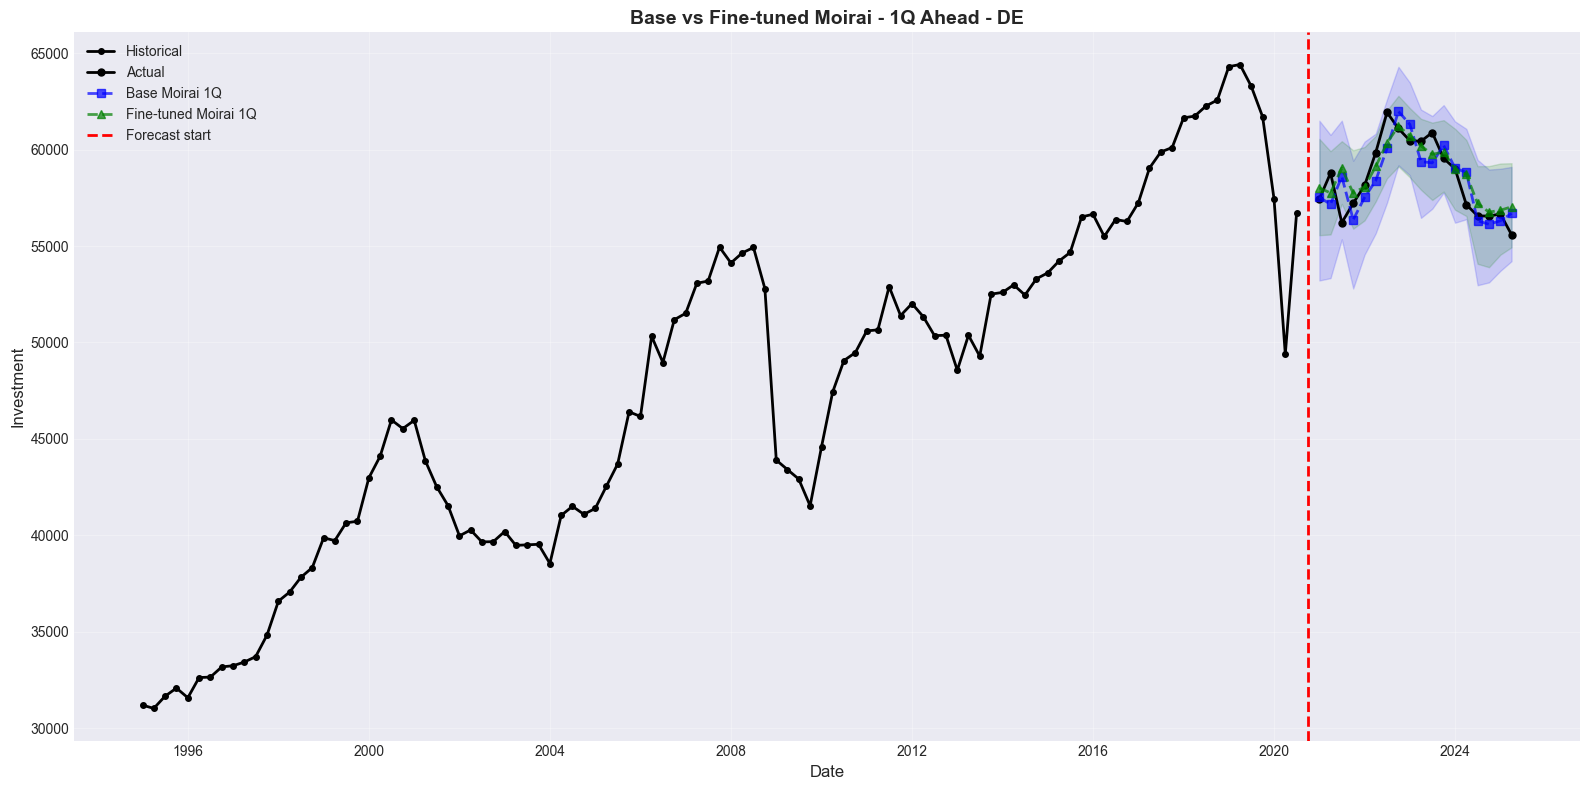

In [12]:
# 1-Quarter ahead forecasts comparison
base_1q = forecasts_base[forecasts_base['horizon_step'] == 1].copy()
ft_1q = forecasts_finetuned[forecasts_finetuned['horizon_step'] == 1].copy()

hist_data = df_full[df_full[ID_COLUMN] == TARGET_COUNTRY].copy()
hist_data = hist_data[hist_data[TIMESTAMP_COLUMN] < pd.to_datetime(RECURSIVE_START_DATE)]

fig, ax = plt.subplots(figsize=(16, 8))

# Historical
ax.plot(hist_data[TIMESTAMP_COLUMN], hist_data[TARGET_COLUMN], 
        'o-', linewidth=2, markersize=4, label='Historical', color='black')

# Actual values in forecast period
actual_mask = base_1q['actual'].notna()
if actual_mask.any():
    ax.plot(base_1q.loc[actual_mask, TIMESTAMP_COLUMN], 
           base_1q.loc[actual_mask, 'actual'], 
           'o-', linewidth=2, markersize=5, label='Actual', color='black')

# Base predictions
ax.plot(base_1q[TIMESTAMP_COLUMN], base_1q['moirai_p50'], 
       's--', linewidth=2, markersize=6, label='Base Moirai 1Q', 
       color='blue', alpha=0.7)
ax.fill_between(base_1q[TIMESTAMP_COLUMN], base_1q['moirai_p10'], base_1q['moirai_p90'],
                alpha=0.15, color='blue')

# Fine-tuned predictions
ax.plot(ft_1q[TIMESTAMP_COLUMN], ft_1q['moirai_p50'], 
       '^--', linewidth=2, markersize=6, label='Fine-tuned Moirai 1Q', 
       color='green', alpha=0.7)
ax.fill_between(ft_1q[TIMESTAMP_COLUMN], ft_1q['moirai_p10'], ft_1q['moirai_p90'],
                alpha=0.15, color='green')

ax.axvline(x=pd.to_datetime(RECURSIVE_START_DATE), color='red', 
          linestyle='--', linewidth=2, label='Forecast start')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Investment', fontsize=12)
ax.set_title(f'Base vs Fine-tuned Moirai - 1Q Ahead - {TARGET_COUNTRY}', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


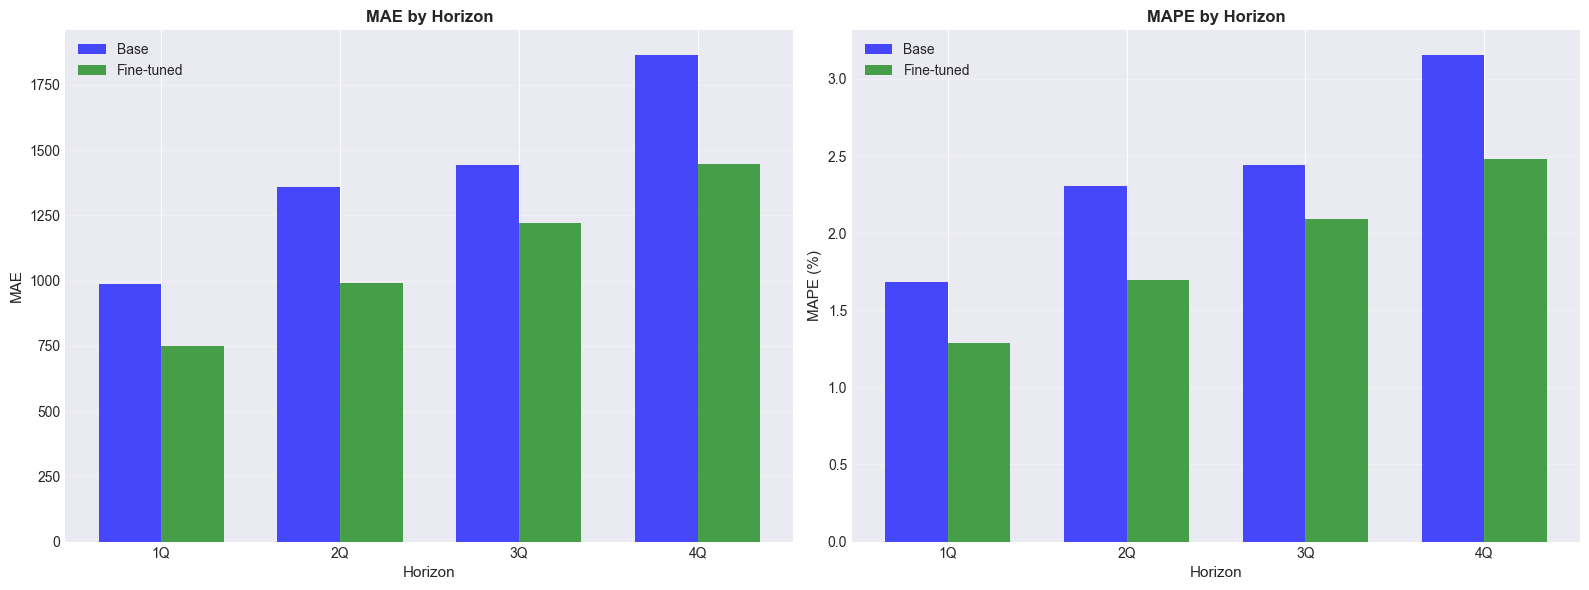

In [13]:
# Error comparison by horizon
if base_by_horizon is not None and ft_by_horizon is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    x = np.arange(len(base_by_horizon))
    width = 0.35
    
    # MAE
    ax = axes[0]
    ax.bar(x - width/2, base_by_horizon['MAE'], width, label='Base', color='blue', alpha=0.7)
    ax.bar(x + width/2, ft_by_horizon['MAE'], width, label='Fine-tuned', color='green', alpha=0.7)
    ax.set_xlabel('Horizon', fontsize=11)
    ax.set_ylabel('MAE', fontsize=11)
    ax.set_title('MAE by Horizon', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(base_by_horizon['Horizon'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # MAPE
    ax = axes[1]
    ax.bar(x - width/2, base_by_horizon['MAPE'], width, label='Base', color='blue', alpha=0.7)
    ax.bar(x + width/2, ft_by_horizon['MAPE'], width, label='Fine-tuned', color='green', alpha=0.7)
    ax.set_xlabel('Horizon', fontsize=11)
    ax.set_ylabel('MAPE (%)', fontsize=11)
    ax.set_title('MAPE by Horizon', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(base_by_horizon['Horizon'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


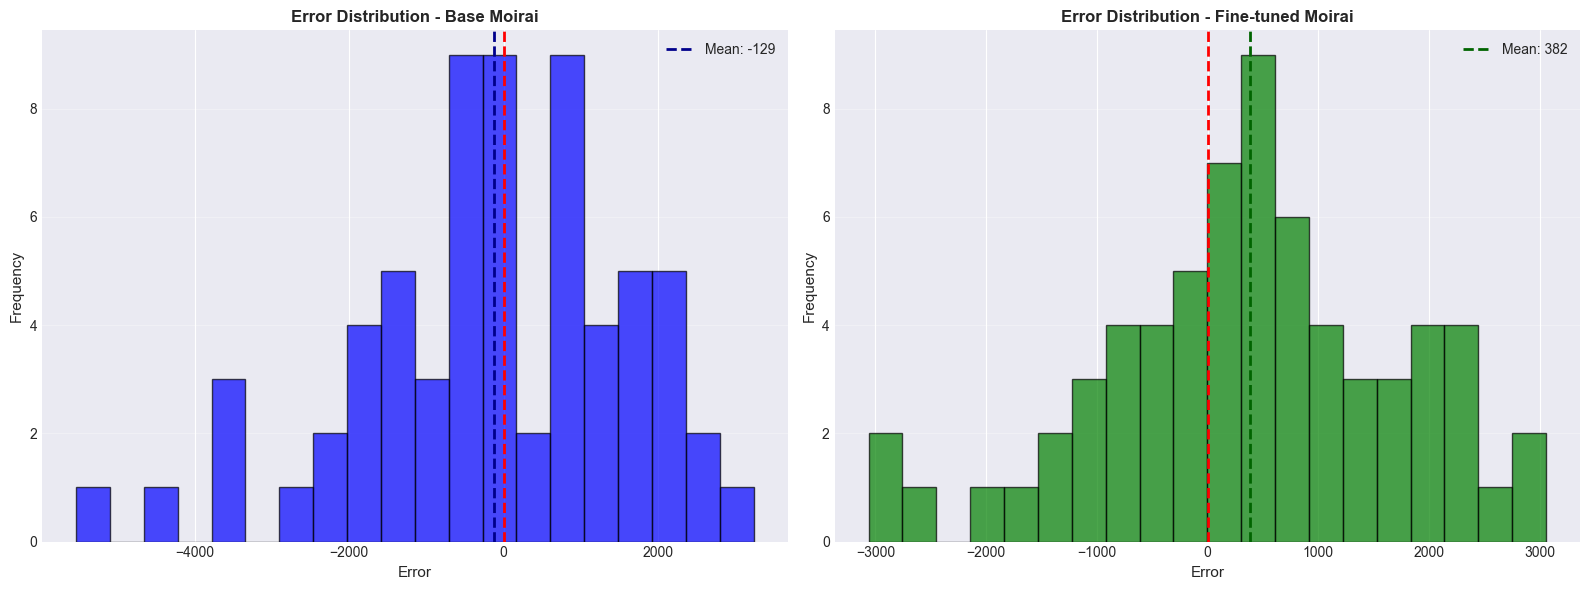

In [14]:
# Error distributions
base_with_actual = forecasts_base[forecasts_base['actual'].notna()].copy()
base_with_actual['error'] = base_with_actual['moirai_p50'] - base_with_actual['actual']

ft_with_actual = forecasts_finetuned[forecasts_finetuned['actual'].notna()].copy()
ft_with_actual['error'] = ft_with_actual['moirai_p50'] - ft_with_actual['actual']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Base
ax = axes[0]
ax.hist(base_with_actual['error'], bins=20, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.axvline(x=base_with_actual['error'].mean(), color='darkblue', 
          linestyle='--', linewidth=2, label=f"Mean: {base_with_actual['error'].mean():.0f}")
ax.set_xlabel('Error', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Error Distribution - Base Moirai', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Fine-tuned
ax = axes[1]
ax.hist(ft_with_actual['error'], bins=20, alpha=0.7, color='green', edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.axvline(x=ft_with_actual['error'].mean(), color='darkgreen', 
          linestyle='--', linewidth=2, label=f"Mean: {ft_with_actual['error'].mean():.0f}")
ax.set_xlabel('Error', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Error Distribution - Fine-tuned Moirai', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Summary

This notebook compared:
- **Base Moirai-2**: Pre-trained model (zero-shot)
- **Fine-tuned Moirai-2**: With LoRA adapters trained on DE investment data

Using the same recursive forecasting methodology as `recursive_forecasting.ipynb` (2020-10-01 to 2025-01-01, 4-quarter horizon).

The performance metrics and visualizations above show whether fine-tuning with LoRA improves forecasting accuracy for this specific use case.
